In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import random

from multiprocessing import Queue as MultiQueue
from queue import Queue
from urllib.parse import urlparse
import requests
from requests import get

from bs4 import BeautifulSoup

## Crawler

### Single Threaded Crawler

In [17]:
class Crawler:
    def __init__(self, seed_urls: str):
        self.q = Queue()
        for url in seed_urls:
            self.q.put(url)
        self.visited_urls = set()
        self.error_urls = set()
        self.visited_pages = dict()

    def _get_unvisited_links(self, page_url: str, page: BeautifulSoup):
        def is_internal(link):
            return not bool(urlparse(link).netloc) or link.startswith(page_url)
        links = {a.get('href', '') for a in page.find_all('a')}
        links = [link for link in links if len(link) > 0]
        for link in links:
            if is_internal(link) and not link.startswith('#'):
                link = f'{page_url}{link}'
            if link.startswith('//'):
                link = f'https:{link}'
            if link not in self.visited_urls:
                yield link

    def _crawl_single(self, url):
        # making the request to the page
        resp = get(url)
        resp.raise_for_status()
        self.visited_urls.add(url)

        # parsing it using bs
        page = BeautifulSoup(resp.content, "html.parser")
        self.visited_pages[url] = page

        # adding links to the bfs queue
        for link in self._get_unvisited_links(url, page):
            self.q.put(link)

    def crawl(self, num_pages: int|None=50):
        num_crawled = 0
        num_error = 0
        while not self.q.empty() and num_crawled + num_error < num_pages:
            url = self.q.get()
            try:
                self._crawl_single(url)
                print(f"visited #{num_crawled+1}: {url}")
                num_crawled += 1
            except Exception as e:
                self.error_urls.add(url)
                print(f'could not visit {url}; exception: {e}')
                num_error += 1

### Concurrent Crawler

In [18]:
class ConcurrentCrawler(Crawler):
    def __init__(self, seed_urls: str):
        self.q = MultiQueue()
        for url in seed_urls:
            self.q.put(url)
        self.visited_urls = set()
        self.error_urls = set()
        self.visited_pages = dict()

    def _crawl_single(self, url):
        # making the request to the page
        resp = get(url)
        resp.raise_for_status()
        self.visited_urls.add(url)

        # parsing it using bs
        page = BeautifulSoup(resp.content, "html.parser")
        self.visited_pages[url] = page

        # adding links to the bfs queue
        for link in self._get_unvisited_links(url, page):
            self.q.put(link, block=True)

    def crawl(self, num_pages: int|None=50):
        num_crawled = 0
        num_error = 0
        while not self.q.empty() and num_crawled + num_error < num_pages:
            url = self.q.get(block=False)
            try:
                self._crawl_single(url)
                print(f"visited #{num_crawled+1}: {url}")
                num_crawled += 1
            except Exception as e:
                self.error_urls.add(url)
                print(f'could not visit {url}; exception: {e}')
                num_error += 1

## Accessibility Evaluation

In [19]:
def alt_tag_percentage(bso) -> float:
    img_tags = bso.find_all('img')
    img_tags_with_alt = [tag for tag in img_tags if tag.has_attr('alt')]
    return len(img_tags_with_alt) / len(img_tags) if len(img_tags) > 0 else 1

In [20]:
def aria_label_links_percentage(bso) -> float:
    tags = bso.find_all('a')
    tags_with_aria_label = [tag for tag in tags if tag.has_attr('aria-label')]
    return len(tags_with_aria_label) / len(tags) if len(tags) > 0 else 1

In [28]:
def aria_link_role_percentage(bso):
    tags = bso.find_all('a')
    tags_with_aria_role = bso.find_all('a', attrs={'role': 'link'})
    return len(tags_with_aria_role) / len(tags) if len(tags) > 0 else 1

In [45]:
def aria_list_role_percentage(bso):
    tags = bso.find_all(['ol', 'ul'])
    tags_with_aria_role = bso.find_all('a', attrs={'role': 'link'})
    return len(tags_with_aria_role) / len(tags) if len(tags) > 0 else 1

In [38]:
def has_aria_main_role(bso):
    return len(bso.find_all(attrs={'role': 'main'})) > 0

In [43]:
def has_aria_nav_role(bso):
    return len(bso.find_all(attrs={'role': 'nav'})) > 0

In [52]:
def has_aria_banner_role(bso):
    return len(bso.find_all(attrs={'role': 'banner'})) > 0

In [53]:
def num_diff_link_phrase(bso) -> int:
    tag_dict = {}
    ans = 0
    a_tags = bso.find_all('a')
    for a in a_tags:
        if not a.has_attr('href'):
            continue
        href = a['href']
        phrase = a.text
        if href in tag_dict and phrase != tag_dict[href]:
            ans += 1
    return ans


In [132]:
def headings_without_roles(bso) -> int:
    headings = bso.find_all(['h1', 'h2', 'h3', 'h4', 'h5', 'h6'])
    count = 0
    for heading in headings:
        if not heading.has_attr('role') and not heading.has_attr('aria-level'):
            count += 1
    return count/len(headings) if len(headings) > 0 else 1

In [133]:
evaluation_methods = {
    'alt_text_percentage': alt_tag_percentage,
    'aria_label_percentage': aria_label_links_percentage,
    'headings_without_roles': headings_without_roles,
    'num_diff_link_phrase': num_diff_link_phrase,
    'aria_list_role_percentage': aria_list_role_percentage,
    'aria_link_role_percentage': aria_link_role_percentage,
    'has_aria_main_role': has_aria_main_role,
    'has_aria_nav_role': has_aria_nav_role,
    'has_aria_banner_role': has_aria_banner_role
}

In [25]:
bso = BeautifulSoup(get('https://evansville.edu').content, "html.parser")

In [39]:
has_aria_main_role(bso)

False

## Crawling NY-Mag and Wikpedia

In [31]:
c1 = Crawler(seed_urls=['https://nymag.com', 'https://en.wikipedia.org/wiki/Main_Page'])
c1.crawl(10)

visited #1: https://nymag.com
visited #2: https://en.wikipedia.org/wiki/Main_Page
visited #3: https://nymag.com/intelligencer/2023/04/the-pentagon-wants-to-know-who-leaked-secret-ukraine-docs.html
visited #4: https://www.grubstreet.com/2023/03/2023-james-beard-awards-nominees.html
visited #5: https://www.grubstreet.com/bestofnewyork/absolute-best-hot-dog-in-nyc.html
visited #6: https://www.grubstreet.com/2023/04/mimi-sheraton-ate-everything-for-us.html
visited #7: https://www.curbed.com/article/ketamine-therapy-office-cardea-randy-polumbo-tour.html
visited #8: https://nymag.com/strategist/fitness/
visited #9: https://www.vulture.com
visited #10: https://subs.nymag.com/account/


In [68]:
results = pd.DataFrame()
for i, (url, page) in enumerate(c1.visited_pages.items()):
    results.loc[i, 'url'] = url
    for name, func in evaluation_methods.items():
        results.loc[i, name] = func(page)
results

,url,alt_text_percentage,aria_label_percentage,headings_without_roles,num_diff_link_phrase,aria_list_role_percentage,aria_link_role_percentage,has_aria_main_role,has_aria_nav_role,has_aria_banner_role
0,https://nymag.com,1.000000,0.002604,1.0,0.0,0.0,0.0,False,False,False
1,https://en.wikipedia.org/wiki/Main_Page,1.000000,0.003030,1.0,0.0,0.0,0.0,True,False,False
2,https://nymag.com/intelligencer/2023/04/the-pe...,0.125000,0.040000,1.0,0.0,0.0,0.0,True,False,False
3,https://www.grubstreet.com/2023/03/2023-james-...,0.178571,0.179310,1.0,0.0,0.0,0.0,True,False,False
4,https://www.grubstreet.com/bestofnewyork/absol...,0.300000,0.145833,1.0,0.0,0.0,0.0,True,False,False
5,https://www.grubstreet.com/2023/04/mimi-sherat...,0.142857,0.197279,1.0,0.0,0.0,0.0,True,False,False
6,https://www.curbed.com/article/ketamine-therap...,0.135135,0.167742,1.0,0.0,0.0,0.0,True,False,False
7,https://nymag.com/strategist/fitness/,0.052632,0.006289,1.0,0.0,0.0,0.0,False,False,False
8,https://www.vulture.com,1.000000,0.005155,1.0,0.0,0.0,0.0,False,False,False
9,https://subs.nymag.com/account/,1.000000,0.012658,1.0,0.0,0.0,0.0,False,False,False


In [ ]:
results.to_csv('nymag-wikipedia.csv')

In [ ]:
results = pd.read_csv('nymag-wikipedia.csv')

In [ ]:
results

,Unnamed: 0,url,alt_text_percentage,aria_label_percentage
0,0,https://nymag.com,1.000000,0.002639
1,1,https://en.wikipedia.org/wiki/Main_Page,1.000000,0.003021
2,2,https://www.vulture.com/article/summer-house-r...,0.888889,0.172222
3,3,https://thecut.com/self,1.000000,0.008197
4,4,https://subs.nymag.com/account/,1.000000,0.012500
...,...,...,...,...
86,86,https://nymag.com/strategist/home,1.000000,0.005464
87,87,https://www.grubstreet.com/2023/02/nyc-city-co...,0.892857,0.183673
88,88,https://www.vulture.com/,1.000000,0.005291
89,89,https://nymag.com/intelligencer/ideas/,1.000000,0.010526


### Plotting

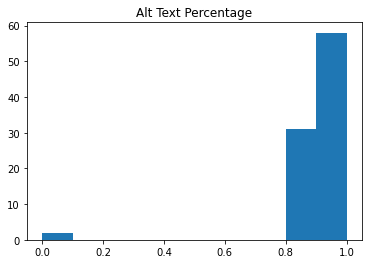

In [ ]:
plt.hist(results['alt_text_percentage'])
plt.title('Alt Text Percentage')
plt.show()

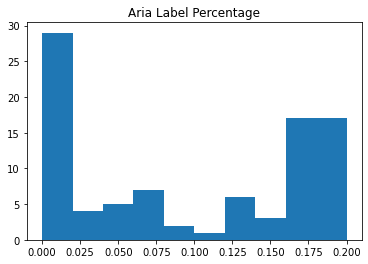

In [ ]:
plt.hist(results['aria_label_percentage'])
plt.title('Aria Label Percentage')
plt.show()

## Feature Engineering

In [48]:
dataset = pd.read_csv('dataset.csv')
dataset

,site,label
0,missouristate.edu,accessible
1,csun.edu,accessible
2,calpoly.edu,accessible
3,illinois.edu,accessible
4,iub.edu,accessible
...,...,...
100,nivea.de,inaccessible
101,pandora.com,inaccessible
102,rogersthankyou.com,inaccessible
103,tdameritrade.com,inaccessible


In [87]:
all_pages = set(dataset['site'])

In [80]:
error_pages = set()
done_pages = set()

In [183]:
remaining_pages = all_pages - (error_pages | done_pages)
print(len(list(remaining_pages)))
remaining_pages

14


{'anandtech.com',
 'fittv.discovery.com/fansites/blaine/recipes/recipes.html',
 'gnome.org',
 'home.uncc.edu',
 'lasalle.edu',
 'marshall.edu',
 'mbl.is',
 'msdn.microsoft.com/en-us/library/microsoft.csharp.csharpcodeprovider.aspx',
 'nytimes.org',
 'smu.edu',
 'tcu.edu',
 'usma.edu',
 'usna.edu',
 'www.americanairlines.in/intl/in/index.jsp'}

In [184]:
remaining_pages.remove('www.americanairlines.in/intl/in/index.jsp')

In [188]:
for site in list(error_pages):
    try:
        print(f'trying for {site}')
        resp = get(f'https://{site}')
        resp.raise_for_status()
        page = BeautifulSoup(resp.content)
        done_pages.add(site)
        print(f'page {site} visited')
    except requests.exceptions.RequestException as e:
        print('Error retrieving ' + site + ': ' + str(e))
        error_pages.add(site)
    except AttributeError as e:
        print('Error parsing ' + site + ': ' + str(e))

trying for duke.edu
page duke.edu visited
trying for myspace.com
Error retrieving myspace.com: HTTPSConnectionPool(host='myspace.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:992)')))
trying for en.wikipedia.org/wiki/Main˙Page
Error retrieving en.wikipedia.org/wiki/Main˙Page: 404 Client Error: Not Found for url: https://en.wikipedia.org/wiki/Main%CB%99Page
trying for arstechnica.org
Error retrieving arstechnica.org: HTTPSConnectionPool(host='arstechnica.org', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f830af1efd0>: Failed to establish a new connection: [Errno -2] Name or service not known'))
trying for www.ku.edu
page www.ku.edu visited
trying for facebook.com
page facebook.com visited
trying for csufresno.edu
page csufresno.edu visited
trying for g

In [190]:
print(len(list(done_pages)))
done_pages

74


{'anandtech.com',
 'apple.com',
 'audible.org',
 'bbc.co.uk',
 'bookshare.org',
 'calpoly.edu',
 'cbc.ca/news',
 'christinefeehan.com',
 'cnet.com',
 'cpan.org',
 'csueastbay.edu',
 'csufresno.edu',
 'csun.edu',
 'csusb.edu',
 'dell.com',
 'duke.edu',
 'dv.is',
 'ecu.edu',
 'evansville.edu',
 'facebook.com',
 'fordham.edu',
 'gbcnv.edu',
 'georgetown.edu',
 'gnome.org',
 'google.com/search?q=ford+raptor',
 'hertz.com',
 'home.uncc.edu',
 'illinois.edu',
 'iub.edu',
 'jetblue.com',
 'lafayette.edu',
 'lasalle.edu',
 'marshall.edu',
 'mbl.is',
 'missouristate.edu',
 'montana.edu',
 'msdn.microsoft.com/en-us/library/microsoft.csharp.csharpcodeprovider.aspx',
 'nivea.de',
 'notepad-plus-plus.org',
 'okstate.edu',
 'pandora.com',
 'providence.edu',
 'psu.edu',
 'siu.edu',
 'smsu.edu',
 'smu.edu',
 'tcu.edu',
 'tdameritrade.com',
 'travisa.com',
 'twin-cities.umn.edu',
 'uab.edu',
 'uc.edu',
 'ucsb.edu',
 'ucsc.edu',
 'uh.edu',
 'uic.edu',
 'usconstitution.net/const.html',
 'usm.edu',
 'usna

In [187]:
print(len(list(error_pages)))
error_pages

94


{'apple.com',
 'arstechnica.org',
 'audible.org',
 'aupeo.com',
 'bbc.co.uk',
 'bestbuy.org',
 'blindbargains.org',
 'bookshare.org',
 'brandonsanderson.org',
 'calpoly.edu',
 'cbc.ca/news',
 'christinefeehan.com',
 'cnet.com',
 'cpan.org',
 'csueastbay.edu',
 'csufresno.edu',
 'csun.edu',
 'csusb.edu',
 'csustan.edu',
 'dell.com',
 'delta.com',
 'duke.edu',
 'dv.is',
 'ecu.edu',
 'en.wikipedia.org/wiki/Main˙Page',
 'evansville.edu',
 'facebook.com',
 'fittv.discovery.com/fansites/blaine/recipes/recipes.html',
 'fmbrewery.com',
 'fordham.edu',
 'gbcnv.edu',
 'genaw.com/lowcarb/burger˙recipes.html',
 'georgetown.edu',
 'germanwings.com/en',
 'google.com/search?q=ford+raptor',
 'harvard.educ.blogs.barrons.com/techtraderdaily',
 'hertz.com',
 'illinois.edu',
 'iub.edu',
 'jetblue.com',
 'lafayette.edu',
 'lenovo.com/us/en',
 'missouristate.edu',
 'mobile.hertz.org',
 'montana.edu',
 'myspace.com',
 'nivea.de',
 'nokia.org',
 'notepad-plus-plus.org',
 'nsc.nevada.edu',
 'nytimes.org',
 'ok

In [191]:
with open('done_pages.txt', 'w') as file:
    for site in list(done_pages):
        file.write(site)
        file.write(',')

In [192]:
train_set = pd.DataFrame()
for i, site in enumerate(list(done_pages)):
    try:
        url = f'https://{site}'
        resp = get(url)
        resp.raise_for_status()
        # print(dataset.loc[dataset['site'] == site]['label'].to_list())
        page = BeautifulSoup(resp.content)
        train_set.loc[i, 'url'] = resp.url
        train_set.loc[i, 'label'] = dataset.loc[dataset['site'] == site]['label'].to_list()[0]
        for name, func in evaluation_methods.items():
            train_set.loc[i, name] = func(page)

        print(f'page #{i}: {site} visited')
    except requests.exceptions.RequestException as e:
        print('Error retrieving ' + site + ': ' + str(e))
    except AttributeError as e:
        print('Error parsing ' + site + ': ' + str(e))


page #0: zorrolegend.blogspot.com/search/label/New%20World%20Zorro%20DVD%20Information visited
page #1: duke.edu visited
page #2: uh.edu visited
page #3: w3.org visited
page #4: wright.edu visited
page #5: www.holycross.edu visited
page #6: nivea.de visited
page #7: www.ku.edu visited
page #8: facebook.com visited
page #9: csufresno.edu visited
page #10: google.com/search?q=ford+raptor visited
page #11: notepad-plus-plus.org visited
page #12: okstate.edu visited
page #13: www.ucsf.edu visited
page #14: christinefeehan.com visited
page #15: fordham.edu visited
page #16: twin-cities.umn.edu visited
page #17: pandora.com visited
page #18: montana.edu visited
page #19: cbc.ca/news visited
page #20: calpoly.edu visited
page #21: usconstitution.net/const.html visited
page #22: www.ttu.edu visited
page #23: dv.is visited
page #24: hertz.com visited
page #25: uab.edu visited
page #26: weber.edu visited
page #27: missouristate.edu visited
page #28: csun.edu visited
page #29: evansville.edu visi

In [193]:
train_set.to_csv('train_set.csv', index=False)
train_set

,url,label,alt_text_percentage,aria_label_percentage,headings_without_roles,num_diff_link_phrase,aria_list_role_percentage,aria_link_role_percentage,has_aria_main_role,has_aria_nav_role,has_aria_banner_role
0,https://zorrolegend.blogspot.com/search/label/...,accessible,0.722222,0.000000,1.0,0.0,0.0,0.0,False,False,False
1,https://duke.edu/,accessible,1.000000,0.000000,1.0,0.0,0.0,0.0,False,False,True
2,https://uh.edu/,accessible,1.000000,0.051020,1.0,0.0,0.0,0.0,False,False,False
3,https://www.w3.org/,accessible,1.000000,0.000000,1.0,0.0,0.0,0.0,False,False,False
4,https://www.wright.edu/,inaccessible,0.740741,0.000000,1.0,0.0,0.0,0.0,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
68,https://www.marshall.edu/,inaccessible,0.764706,0.013216,1.0,0.0,1.0,0.0,True,False,False
69,https://www.usm.edu/,inaccessible,1.000000,0.000000,1.0,0.0,0.0,0.0,False,False,False
70,https://www.indiana.edu/,accessible,1.000000,0.072917,1.0,0.0,0.0,0.0,False,False,False
71,https://www.csusb.edu/,accessible,1.000000,0.000000,1.0,0.0,0.0,0.0,False,False,False


In [189]:
train_set['label'].value_counts()

accessible      33
inaccessible    28
Name: label, dtype: int64

## Dataset 2

In [227]:
dataset_2_raw = pd.read_csv('./dataset_2.csv')
dataset_2 = pd.DataFrame()
dataset_2['url'] = dataset_2_raw['URL']
dataset_2['label'] = dataset_2_raw['Percentage of site inaccessible'].apply(
    lambda x: 'inaccessible' if float(x[:-1]) > 0.5 else 'accessible'
)
dataset_2

,url,label
0,https://www.nih.gov/,accessible
1,https://www.cdc.gov/,accessible
2,https://gov.uk/,accessible
3,https://in.linkedin.com/,accessible
4,https://www2.hm.com/en_in/index.html,accessible
...,...,...
71,https://www.nordstrom.com/,inaccessible
72,https://www.nike.com/in/,inaccessible
73,https://in.yahoo.com/,inaccessible
74,https://outlook.live.com/,inaccessible


In [229]:
train_set_2 = pd.DataFrame()
for i, url in enumerate(dataset_2['url']):
    try:
        print(f'trying for {url}')
        resp = get(url)
        resp.raise_for_status()
        # print(dataset.loc[dataset['site'] == site]['label'].to_list())
        page = BeautifulSoup(resp.content)
        train_set_2.loc[i, 'url'] = resp.url
        train_set_2.loc[i, 'label'] = dataset_2.loc[dataset_2['url'] == url]['label'].to_list()[0]
        for name, func in evaluation_methods.items():
            train_set_2.loc[i, name] = func(page)
        print(f'page #{i}: {url} visited')
    except requests.exceptions.RequestException as e:
        print('Error retrieving ' + url + ': ' + str(e))
    except AttributeError as e:
        print('Error parsing ' + url + ': ' + str(e))

trying for https://www.nih.gov/
page #0: https://www.nih.gov/ visited
trying for https://www.cdc.gov/
page #1: https://www.cdc.gov/ visited
trying for https://gov.uk/
page #2: https://gov.uk/ visited
trying for https://in.linkedin.com/
page #3: https://in.linkedin.com/ visited
trying for https://www2.hm.com/en_in/index.html
Error retrieving https://www2.hm.com/en_in/index.html: 403 Client Error: Forbidden for url: https://www2.hm.com/en_in/index.html
trying for https://www.paypal.com/
page #5: https://www.paypal.com/ visited
trying for https://www.mayoclinic.org/
page #6: https://www.mayoclinic.org/ visited
trying for https://www.ups.com/in/en/Home.page
page #7: https://www.ups.com/in/en/Home.page visited
trying for https://www.capitalone.com/
page #8: https://www.capitalone.com/ visited
trying for https://www.amazon.in/
page #9: https://www.amazon.in/ visited
trying for https://www.instagram.com/
page #10: https://www.instagram.com/ visited
trying for https://telegram.org/
page #11: h

KeyboardInterrupt: 

In [233]:
train_set_2
final_train_set = pd.concat([train_set, train_set_2])
final_train_set.to_csv('train_set.csv', index=False)